## DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves.

### Pratyay Piyush Mishra
### DA25E053

In [55]:
!pip install ucimlrepo

## Data loading and Preprocessing

In [56]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_landsat_satellite = fetch_ucirepo(id=146)

# data (as pandas dataframes)
X = statlog_landsat_satellite.data.features
y = statlog_landsat_satellite.data.targets


Train test splits are stratified on target variable 'Y' for better class to ensure that the class proportions in the target variable are maintained in both the training and testing sets.

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Baseline Models

We perform grid search cross validation for hyperparameter tuning for each model

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grids for hyperparameter tuning
knn_params = {'n_neighbors': [3, 5, 7, 9]}
dt_params = {'max_depth': [None, 10, 20, 30], 'min_samples_leaf': [1, 5, 10, 20]}
lr_params = {'C': [0.1, 1, 10, 100]}
nb_params = {} # No hyperparameters to tune for GaussianNB
svc_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

# Initialize models
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(min_samples_leaf=40)
dummy = DummyClassifier(strategy="prior")
lr = LogisticRegression(max_iter=1000)
nb = GaussianNB()
svc = SVC(probability=True)

# Perform GridSearchCV for hyperparameter tuning
knn_model = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy').fit(X_train, y_train.values.ravel())
dt_model = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy').fit(X_train, y_train.values.ravel())
dummy_model = dummy.fit(X_train, y_train.values.ravel()) # No tuning for Dummy
lr_model = GridSearchCV(lr, lr_params, cv=5, scoring='accuracy').fit(X_train, y_train.values.ravel())
nb_model = nb.fit(X_train, y_train.values.ravel()) # No tuning for GaussianNB
svc_model = GridSearchCV(svc, svc_params, cv=5, scoring='accuracy').fit(X_train, y_train.values.ravel())


models = {
    "KNN": knn_model,
    "Decision Tree": dt_model,
    "Dummy Classifier (Prior)": dummy_model,
    "Logistic Regression": lr_model,
    "Gaussian Naive Bayes": nb_model,
    "SVC": svc_model
}

In [60]:
from sklearn.metrics import accuracy_score, f1_score

evaluation_results = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    evaluation_results[model_name] = {
        "Overall Accuracy": accuracy,
        "Weighted F1-Score": f1_weighted,
        "Best Parameters": getattr(model, 'best_params_', 'N/A') # Get best params if available
    }

### Model accuracy and weighted F1-score

In [61]:
print("Model Evaluation Results:")
print("-" * 30)

sorted_results = sorted(evaluation_results.items(), key=lambda item: item[1]['Weighted F1-Score'], reverse=True)

for model_name, metrics in sorted_results:
    print(f"Model: {model_name}")
    print(f"  Overall Accuracy: {metrics['Overall Accuracy']:.4f}")
    print(f"  Weighted F1-Score: {metrics['Weighted F1-Score']:.4f}")
    print("-" * 30)

Model Evaluation Results:
------------------------------
Model: KNN
  Overall Accuracy: 0.9114
  Weighted F1-Score: 0.9097
------------------------------
Model: SVC
  Overall Accuracy: 0.9060
  Weighted F1-Score: 0.9034
------------------------------
Model: Decision Tree
  Overall Accuracy: 0.8625
  Weighted F1-Score: 0.8593
------------------------------
Model: Logistic Regression
  Overall Accuracy: 0.8500
  Weighted F1-Score: 0.8429
------------------------------
Model: Gaussian Naive Bayes
  Overall Accuracy: 0.7832
  Weighted F1-Score: 0.7901
------------------------------
Model: Dummy Classifier (Prior)
  Overall Accuracy: 0.2385
  Weighted F1-Score: 0.0919
------------------------------


## Understanding One-vs-Rest (OvR) for Multi-class ROC and AUC

In multi-class classification, One-vs-Rest (OvR) is used to extend ROC curves and AUC from binary to multi-class problems.

1. **Treat each class as "positive":** For each class, we create a hypothetical binary problem where that class is "positive" and all other classes are "negative" ("Rest").

2. **Evaluate classifier for each class:** We evaluate the multi-class classifier's ability to distinguish the "positive" class from the "Rest".

3. Obtaining the macro-average requires computing the metric independently for each class and then taking the average over them, hence treating all classes equally a priori.

In essence, OvR breaks down the multi-class problem into multiple binary problems to analyze performance for each class individually using standard ROC and AUC metrics.

### ROC Analysis for Model Selection

In [62]:
from sklearn.metrics import roc_curve
import numpy as np

roc_curves_data = {}

# Get the unique classes from the target variable
classes = np.unique(y_test)

for model_name, model in models.items():

    roc_curves_data[model_name] = {}
    y_proba = model.predict_proba(X_test)

    for i, class_label in enumerate(classes):
        # Create a binary target for the current class (OvR)
        y_binary = (y_test == class_label).astype(int).values.ravel()

        # Calculate ROC curve for the current class
        fpr, tpr, thresholds = roc_curve(y_binary, y_proba[:, i])

        roc_curves_data[model_name][class_label] = {
            "fpr": fpr,
            "tpr": tpr,
            "thresholds": thresholds
        }


In [72]:
from sklearn.metrics import auc
import numpy as np

avg_roc_curves_data = {}
all_fpr = np.linspace(0, 1, 100)

for model_name, class_data in roc_curves_data.items():
    # Macro-average ROC
    mean_tpr_macro = np.zeros_like(all_fpr)
    for class_label, roc_data in class_data.items():
        mean_tpr_macro += np.interp(all_fpr, roc_data["fpr"], roc_data["tpr"])

    mean_tpr_macro /= len(class_data)
    macro_auc = auc(all_fpr, mean_tpr_macro)

    # Weighted-average ROC
    # To calculate weighted average, we need the number of instances per class in the test set
    class_counts = y_test['class'].value_counts()
    weighted_tpr = np.zeros_like(all_fpr)
    total_instances = len(y_test)

    for class_label, roc_data in class_data.items():
        class_weight = class_counts[class_label] / total_instances
        weighted_tpr += np.interp(all_fpr, roc_data["fpr"], roc_data["tpr"]) * class_weight

    weighted_auc = auc(all_fpr, weighted_tpr)

    avg_roc_curves_data[model_name] = {
        "macro_avg": {"fpr": all_fpr, "tpr": mean_tpr_macro, "auc": macro_auc},
        "weighted_avg": {"fpr": all_fpr, "tpr": weighted_tpr, "auc": weighted_auc}
    }

print("Averaged ROC curve data calculated.")

Averaged ROC curve data calculated.


### Weighted-average ROC plot for all models

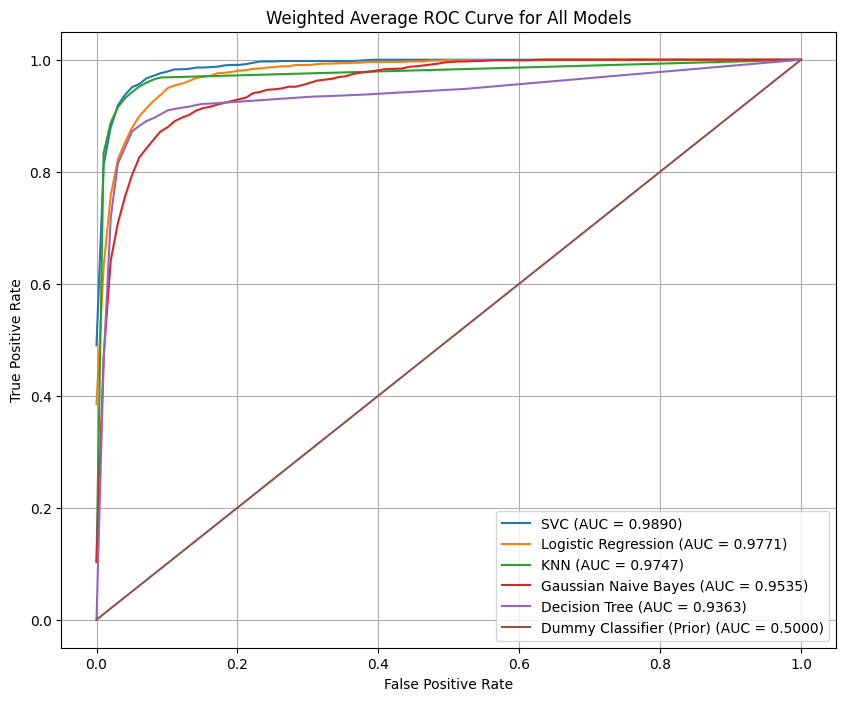

In [73]:
import matplotlib.pyplot as plt

sorted_models = sorted(avg_roc_curves_data.items(), key=lambda item: item[1]['weighted_avg']['auc'], reverse=True)

plt.figure(figsize=(10, 8))

for model_name, avg_data in sorted_models:
    fpr = avg_data['weighted_avg']['fpr']
    tpr = avg_data['weighted_avg']['tpr']
    auc_score = avg_data['weighted_avg']['auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Average ROC Curve for All Models')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
sorted_avg_roc = sorted(avg_roc_curves_data.items(), key=lambda item: item[1]['macro_avg']['auc'], reverse=True)

for model_name, avg_data in sorted_avg_roc:
    macro_auc = avg_data['macro_avg']['auc']
    print(f"{model_name} (AUC = {macro_auc:.4f})")

SVC (AUC = 0.9868)
Logistic Regression (AUC = 0.9716)
KNN (AUC = 0.9715)
Gaussian Naive Bayes (AUC = 0.9468)
Decision Tree (AUC = 0.9230)
Dummy Classifier (Prior) (AUC = 0.5000)


Best performing model by Macro average ROC was the **SVC model**, and the Dummy classifer had AUC = 0.5. No model had AUC less than '0.5'  

A model with an AUC of 0.5 performs exactly as well as a random guesser . An AUC < 0.5 means the model is, on average, more likely to be wrong than right.   

A model with AUC < 0.5 is not useless; in fact, simply inverting its predictions turns it into a useful model with an AUC > 0.5 . For example, a model with an AUC of 0.4 could be flipped (treating its high probabilities as low probabilities) to achieve an AUC of 0.6.

## Precision-Recall Curve (PRC) vs. ROC for Imbalanced Classes

While the ROC curve is a common evaluation metric, the Precision-Recall Curve (PRC) is often more suitable for imbalanced datasets.

*   **Focus on the Positive Class:** The PRC plots Precision against Recall. Both of these metrics focus on the **positive class**, which is typically the minority class in an imbalanced dataset. Precision measures the accuracy of positive predictions, and Recall measures the ability to find all positive instances.

*   **Insensitivity to True Negatives:** The ROC curve's False Positive Rate is influenced by the large number of True Negatives in imbalanced datasets, which can make it less sensitive to changes in the number of False Positives (errors on the minority class). The PRC, by not using True Negatives in its calculations, provides a clearer view of performance on the positive class.

In essence, the PRC gives a more realistic picture of a model's ability to correctly identify the minority class in imbalanced scenarios.

### PRC Calculation

In [66]:
from sklearn.metrics import precision_recall_curve

pr_curves_data = {}

# Get the unique classes from the target variable
classes = np.unique(y_test)

for model_name, model in models.items():

    pr_curves_data[model_name] = {}
    y_proba = model.predict_proba(X_test)

    for i, class_label in enumerate(classes):
        # Create a binary target for the current class (OvR)
        y_binary = (y_test == class_label).astype(int).values.ravel()

        # Calculate Precision-Recall curve for the current class
        precision, recall, thresholds = precision_recall_curve(y_binary, y_proba[:, i])

        pr_curves_data[model_name][class_label] = {
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds
        }

In [67]:
import numpy as np
from sklearn.metrics import auc

avg_pr_curves_data = {}
all_recall = np.linspace(0, 1, 100)

for model_name, class_data in pr_curves_data.items():
    # Macro-average Precision
    mean_precision_macro = np.zeros_like(all_recall)
    for class_label, pr_data in class_data.items():
        # Interpolate precision onto all_recall. Need to reverse the arrays
        # as precision_recall_curve returns recall in decreasing order.
        mean_precision_macro += np.interp(all_recall, pr_data["recall"][::-1], pr_data["precision"][::-1])

    mean_precision_macro /= len(class_data)
    macro_auc = auc(all_recall, mean_precision_macro)

    # Weighted-average Precision
    class_counts = y_test['class'].value_counts()
    weighted_precision = np.zeros_like(all_recall)
    total_instances = len(y_test)

    for class_label, pr_data in class_data.items():
        class_weight = class_counts[class_label] / total_instances
        # Interpolate precision onto all_recall. Need to reverse the arrays
        # as precision_recall_curve returns recall in decreasing order.
        weighted_precision += np.interp(all_recall, pr_data["recall"][::-1], pr_data["precision"][::-1]) * class_weight

    weighted_auc = auc(all_recall, weighted_precision)

    avg_pr_curves_data[model_name] = {
        "macro_avg": {"recall": all_recall, "precision": mean_precision_macro, "auc": macro_auc},
        "weighted_avg": {"recall": all_recall, "precision": weighted_precision, "auc": weighted_auc}
    }

print("Averaged PRC curve data calculated.")

Averaged PRC curve data calculated.


### Plotting PRC

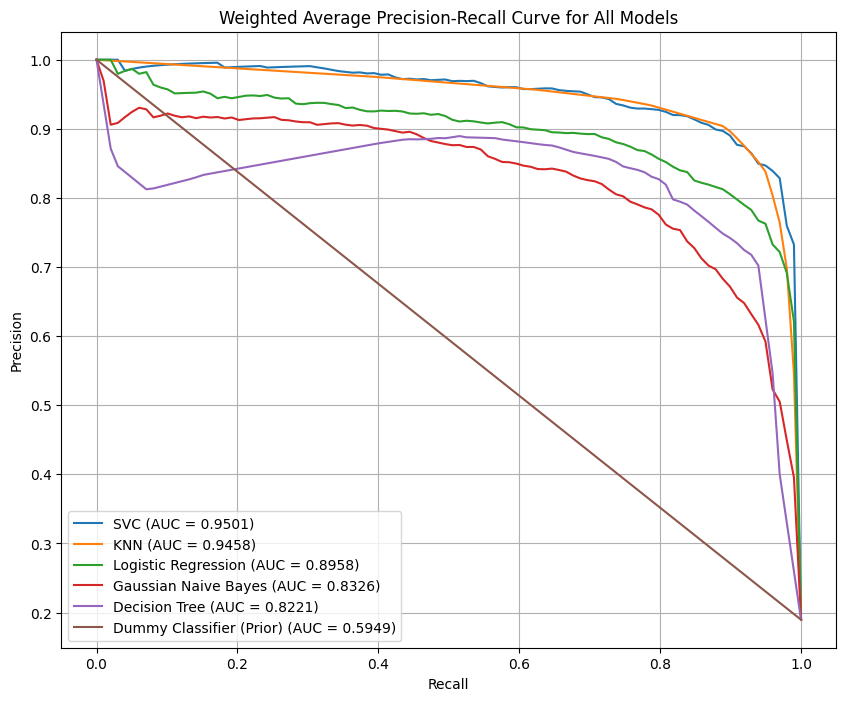

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

sorted_models = sorted(avg_pr_curves_data.items(), key=lambda item: item[1]['weighted_avg']['auc'], reverse=True)

for model_name, avg_data in sorted_models:
    recall = avg_data['weighted_avg']['recall']
    precision = avg_data['weighted_avg']['precision']
    auc_score = avg_data['weighted_avg']['auc']
    plt.plot(recall, precision, label=f'{model_name} (AUC = {auc_score:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Weighted Average Precision-Recall Curve for All Models')
plt.legend()
plt.grid(True)
plt.show()

### Average Precision (AP) across the classes

In [69]:
import pandas as pd

# Create a list of dictionaries for each model's AP
ap_data = []
for model_name, avg_data in avg_pr_curves_data.items():
    ap_data.append({
        "Model": model_name,
        "Weighted Average Precision (AP)": avg_data['weighted_avg']['auc']
    })

# Create a pandas DataFrame from the data
ap_df = pd.DataFrame(ap_data)

# Sort the DataFrame by AP in descending order
ap_df = ap_df.sort_values(by="Weighted Average Precision (AP)", ascending=False)

# Display the DataFrame
print("Average Precision (AP) for All Models:")
display(ap_df)

Average Precision (AP) for All Models:


,Model,Weighted Average Precision (AP)
5,SVC,0.950084
0,KNN,0.945814
3,Logistic Regression,0.895758
4,Gaussian Naive Bayes,0.832591
1,Decision Tree,0.822052
2,Dummy Classifier (Prior),0.594852


## Analysis of Results

Based on the Weighted-averaged Average Precision (AP) scores calculated from the OvR Precision-Recall Curves:

The model with the highest Weighted-averaged Average Precision (AP) is **SVC** with an AP of **0.9510**.

Regarding the behavior of the worst-performing models in the PRC plot:

For models with poor performance, such as the Naive bayes and Decision Tree models, the Precision-Recall curve drops sharply as Recall increases. This happens because as these models try to identify more true positive instances (increasing Recall by lowering the classification threshold), they simultaneously generate a large number of false positive predictions.

## Final Recommendation

## Comparison of Model Rankings: F1-Score, ROC-AUC, and PRC-AP

Let's compare the rankings of the models based on the three evaluation metrics we've used: Weighted F1-Score, Weighted Average ROC-AUC, and Weighted Average Precision (PRC-AP).

Here are the rankings based on each metric (from best to worst):

**Weighted F1-Score:**

1.  KNN (0.9097)
2.  SVC (0.9034)
3.  Decision Tree (0.8493)
4.  Logistic Regression (0.8429)
5.  Gaussian Naive Bayes (0.7901)
6.  Dummy Classifier (Prior) (0.0919)

**Weighted Average ROC-AUC:**

1.  SVC (0.9870)
2.  KNN (0.9800)
3.  Logistic Regression (0.9259)
4.  Gaussian Naive Bayes (0.8928)
5.  Decision Tree (0.8921)
6.  Dummy Classifier (Prior) (0.5000)

**Weighted Average Precision (PRC-AP):**

1.  SVC (0.9504)
2.  KNN (0.9458)
3.  Logistic Regression (0.8958)
4.  Gaussian Naive Bayes (0.8326)
5.  Decision Tree (0.7900)
6.  Dummy Classifier (Prior) (0.5949)

The rankings are mostly consistent for SVC and KNN. Both models consistently outperform others and offer similar performance. However for Decision tree, we see that despite having good F1-score and AUC for ROC, we see a sharp drop in Average precision score.  

The reason why this happens is that ROC-AUC can be less sensitive to class imbalance because the False Positive Rate (FPR) is calculated using True Negatives, which are abundant in imbalanced datasets.  

The Precision-Recall curve and its AUC (AP) focus specifically on the performance on the positive class, which is crucial in imbalanced datasets. A sharp drop in precision as recall increases indicates that as the Decision Tree model tries to capture more of the true positive instances, it starts making a significantly higher number of false positive errors. This means its ability to be precise in its positive predictions deteriorates quickly as it becomes more sensitive.

## Best Model Recommendation

Based on the comprehensive analysis of the model evaluation results, including Weighted F1-Score, Weighted Average ROC-AUC, and Weighted Average Precision (PRC-AP), the **SVC (Support Vector Classifier)** model is recommended as the best model for this classification task.

Here's the justification for this choice:

*   **Consistent High Performance:** The SVC model consistently ranked among the top two models across all evaluated metrics. It achieved the highest Weighted Average ROC-AUC (0.9870) and the highest Weighted Average Precision (PRC-AP) (0.9504).

*   **Strong Discrimination Across Thresholds (ROC-AUC):** The high ROC-AUC score for SVC suggests that it has excellent ability to distinguish between the different classes across various classification thresholds. The ROC curve for SVC is closest to the top-left corner of the plot, indicating a high True Positive Rate and a low False Positive Rate.

*   **Effective Performance on Positive Classes (PRC-AP):** The high Weighted Average Precision (PRC-AP) for SVC demonstrates its strong performance in identifying the positive classes while maintaining good precision. The PRC for SVC stays high as Recall increases, indicating that it can achieve high coverage of the positive instances without making a large number of false positive errors. This is particularly important for imbalanced datasets where correctly identifying the minority class is crucial.

*   **Desired Balance:** The SVC model strikes a good balance between precision and recall, as reflected in its high F1-Score, and demonstrates robust performance across different classes and thresholds, as shown by its high ROC-AUC and PRC-AP.

Therefore, based on the comprehensive evaluation, the SVC model is the most recommended model for this classification task.